###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Music genre classification with naive Bayes


In [1]:
# Importing relevant libraries and functions
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [2]:
def preprocess(filename):
    """
    This function prepares the data by reading it from a file (filename) and
    converts it into a useful format for training and testing
    """
    
    data = pd.read_csv(filename)
    
    # remove the first column
    data = data.iloc[:, 1:]
    return data

In [3]:
def calc_prior(data):
    """
    This function calculates the prior probabilities from the data.
    """
    prior_prob = {}

    labels = data.values[:, -1]
    n = len(labels)
    unique_labels, counts = np.unique(labels, return_counts=True)

    for i in range(len(unique_labels)):
        prior_prob[unique_labels[i]] = (counts[i] / n)

    return prior_prob

In [4]:
def train(data):
    """
    This function trains the data by calculating prior probabilities
    and stores the mean and variance of each features into dataframes
    """

    prior_prob = calc_prior(data)
    mean_values = data.groupby('label').mean()
    var_values = data.groupby('label').var()
    
    return prior_prob, mean_values, var_values


In [5]:
def calc_likelihood(value, feature, label, mean_values, var_values):
    """
    This function calculates the probability density based on gaussian 
    distribution with mean and variance calculated from the training data
    """
    
    # To avoid zero density
    eps = 1e-15
    
    mean = mean_values[feature][label]
    var = var_values[feature][label]
    p = (1 / math.sqrt(2 * math.pi * var + eps)) * math.exp(-((value-mean)**2) / (2 * var + eps))
    
    if not p:
        return eps
    return p

In [6]:
def calc_posterior(data, prior_prob, mean_values, var_values):
    """
    This function calculates the posterior probabilities using the function
    calc_likelihood and returns the list of posterior log-probability densities.
    """
    
    posterior_probs = []
    features_list = list(data.columns)[:-1]

    for _, instance in data.iterrows():
        post_probs = {}
        for label in prior_prob:
            post_probs[label] = math.log(prior_prob[label])
            for feature in features_list:
                likelihood = calc_likelihood(instance[feature], feature, label, mean_values, var_values)
                post_probs[label] += math.log(likelihood)
        posterior_probs.append(post_probs)
    return posterior_probs

In [7]:
def predict(data, prior_prob, mean_values, var_values):
    """
    This function predicts classes for new items in a test dataset.
    """
    posterior_probs = calc_posterior(data, prior_prob, mean_values, var_values)

    argmax_labels = []
    for post_prob in posterior_probs:
        max_prob = -float("inf")
        max_label = None
        for label in post_prob:
            if label in prior_prob:
                prob = post_prob[label]
                if prob > max_prob:
                    max_prob = prob
                    max_label = label
        if max_label is not None:
            argmax_labels.append(max_label)
    return argmax_labels

In [8]:
# This function should evaluate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(true_labels, predictions, positive_label):
    """
    This function evaluates the prediction performance by comparing the model's
    class outputs to ground truth labels. This function calculates and prints
    the accuracy, precision and recall scores given the true labels, predicted 
    labels and positive label as parameters.
    """

    # Calculate the scores
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, pos_label = positive_label)
    recall = recall_score(true_labels, predictions, pos_label = positive_label)
    
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    return

### Evaluation

In [9]:
# Preprocess and train the data
train_data = preprocess("data/pop_vs_classical_train.csv")
test_data = preprocess("data/pop_vs_classical_test.csv")
prior_prob, mean, var = train(train_data)

# Predict and evaluate the performance on test data
predictions = predict(test_data, prior_prob, mean, var)
true_labels = test_data['label'].tolist()
evaluate(true_labels, predictions, 'classical')

Accuracy:  0.9767441860465116
Precision:  0.9523809523809523
Recall:  1.0


### Feature Analysis
- spectral centroid mean
- harmony mean
- tempo

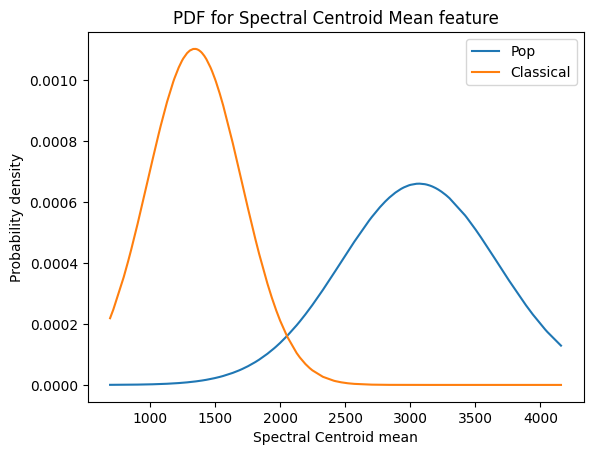

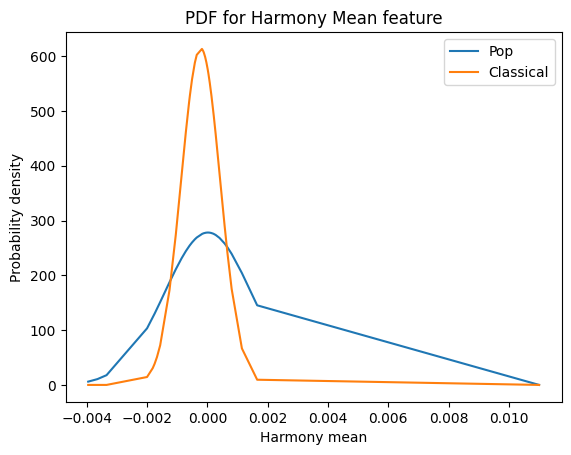

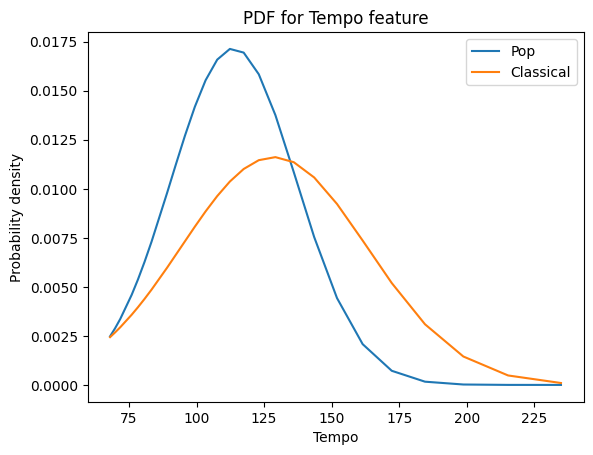

In [10]:
# get the feature from the data
spectral_centroid_mean = train_data['spectral_centroid_mean']
harmony_mean = train_data['harmony_mean']
tempo = train_data['tempo']

# Plot of Probability density function of Spectral Centroid mean 
# given label=pop and label=classical
plt.plot(spectral_centroid_mean.sort_values(), 
         stats.norm.pdf(spectral_centroid_mean.sort_values(), 
                        mean['spectral_centroid_mean']['pop'], 
                        math.sqrt(var['spectral_centroid_mean']['pop'])))
plt.plot(spectral_centroid_mean.sort_values(), 
         stats.norm.pdf(spectral_centroid_mean.sort_values(), 
                        mean['spectral_centroid_mean']['classical'], 
                        math.sqrt(var['spectral_centroid_mean']['classical'])))
plt.xlabel("Spectral Centroid mean")
plt.ylabel("Probability density")
plt.legend(["Pop", "Classical"])
plt.title("PDF for Spectral Centroid Mean feature")
plt.show()

# Plot of Probability density function of Harmony mean 
# given label=pop and label=classical
plt.plot(harmony_mean.sort_values(), 
         stats.norm.pdf(harmony_mean.sort_values(), 
                        mean['harmony_mean']['pop'], 
                        math.sqrt(var['harmony_mean']['pop'])))
plt.plot(harmony_mean.sort_values(), 
         stats.norm.pdf(harmony_mean.sort_values(), 
                        mean['harmony_mean']['classical'], 
                        math.sqrt(var['harmony_mean']['classical'])))
plt.xlabel("Harmony mean")
plt.ylabel("Probability density")
plt.legend(["Pop", "Classical"])
plt.title("PDF for Harmony Mean feature")
plt.show()


# Plot of Probability density function of Tempo
# given label=pop and label=classical

# Using the sorted values to plot the pdf
plt.plot(tempo.sort_values(), 
         stats.norm.pdf(tempo.sort_values(), mean['tempo']['pop'], 
                               math.sqrt(var['tempo']['pop'])))
plt.plot(tempo.sort_values(), 
         stats.norm.pdf(tempo.sort_values(), mean['tempo']['classical'], 
                               math.sqrt(var['tempo']['classical'])))
plt.xlabel("Tempo")
plt.ylabel("Probability density")
plt.legend(["Pop", "Classical"])
plt.title("PDF for Tempo feature")
plt.show()


### Cross-validation with different test sizes

In [12]:
# Read and prepare the data
gztan_train = preprocess("data/gztan_train.csv")
gztan_test = preprocess("data/gztan_test.csv")
gztan = [gztan_train, gztan_test]
gztan_data = pd.concat(gztan)

In [13]:
for k in [2, 3, 5, 10, 100]:

    # since the data is sorted, we shuffle before splitting into 
    # train and test data
    kf = KFold(n_splits = k, shuffle=True, random_state=k)
    
    accuracy = []
    precision = []
    recall = []
    printed_report = False

    for train_idx, test_idx in kf.split(gztan_data):
        train_split = gztan_data.iloc[train_idx]
        test_split = gztan_data.iloc[test_idx]
        
        # train the model
        prior_prob, mean, var = train(train_split)
        # test the model on test data
        predictions = predict(test_split, prior_prob, mean, var)
        true_labels = test_split['label'].tolist()
        
        # calculate the performance scores
        accuracy.append(accuracy_score(true_labels, predictions))

        # Since the data is fairly balanced, we calculate the macro average
        # instead of weighted average
        precision.append(precision_score(true_labels, predictions, average='macro', zero_division=0))
        recall.append(recall_score(true_labels, predictions, average='macro', zero_division=0))

        if not printed_report and k==2:
            print(classification_report(true_labels, predictions, zero_division=0))
            printed_report = True

    print('{0}-fold cv metrics: '.format(k))
    print("Accuracy: ", np.mean(accuracy))
    print("Precision: ", np.mean(precision))
    print("Recall: ", np.mean(recall))
    print()

              precision    recall  f1-score   support

       blues       0.36      0.29      0.32        45
   classical       0.89      0.80      0.84        49
     country       0.45      0.61      0.52        56
       disco       0.35      0.47      0.40        49
      hiphop       0.62      0.33      0.43        55
        jazz       0.70      0.55      0.61        55
       metal       0.45      0.84      0.58        49
         pop       0.67      0.70      0.68        43
      reggae       0.55      0.49      0.52        53
        rock       0.27      0.13      0.18        46

    accuracy                           0.52       500
   macro avg       0.53      0.52      0.51       500
weighted avg       0.53      0.52      0.51       500

2-fold cv metrics: 
Accuracy:  0.537
Precision:  0.5509174297721278
Recall:  0.5353445840658486

3-fold cv metrics: 
Accuracy:  0.5299820778862695
Precision:  0.5346789622054713
Recall:  0.5309448728611526

5-fold cv metrics: 
Accuracy:  0.5